In [1]:
from typing import List, Dict
from collections import Counter
import math

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
import sys
sys.path.insert(0, '../')
from support.probability import inverse_normal_cdf

In [5]:
# self written in python
from support.statistics import correlation

In [6]:
def bucketize(point: float, bucket_size: float) -> float:
    """Floor - point to next lower multiple of bucket_size"""
    return bucket_size * math.floor(point/bucket_size)

In [7]:
def make_histogram(points: List[float], bucket_size: float) -> Dict[float, int]:
    """Buckets the points and counts how many in each bucket"""
    return Counter(bucketize(point, bucket_size) for point in points)

In [8]:
def plot_histogram(points: List[float], bucket_size: float, title: str = ""):
    histogram = make_histogram(points, bucket_size)
    plt.bar(histogram.keys(), histogram.values(), width=bucket_size)
    plt.title(title)

In [9]:
# seed - reproducibility
np.random.seed(42)

### Now, 2 sets of data

In [10]:
import random

random.seed(0)

In [11]:
# uniform b/w -100 and 100

uniform = [200 * random.random() - 100 for _ in range(10000)]

In [12]:
# normal distribution with mean 0, standard deviation 57
normal = [57 * inverse_normal_cdf(random.random())
         for _ in range(10000)]

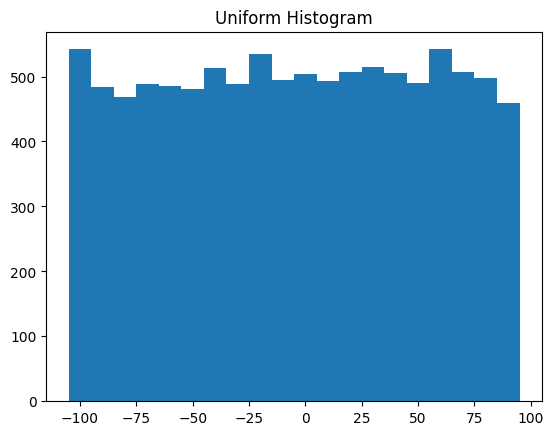

In [13]:
plot_histogram(uniform, 10, "Uniform Histogram")

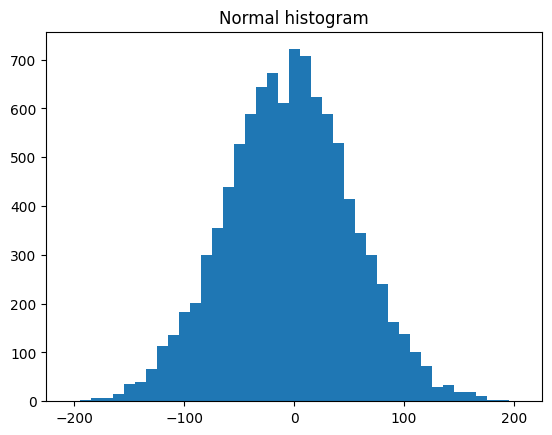

In [14]:
plot_histogram(normal, 10, "Normal histogram")

## Two dimensions

In [15]:
# consider a fake dataset
def random_normal() -> float:
    """Returns a random draw from a standard normal distribution"""
    return inverse_normal_cdf(random.random())

In [16]:
xs = [random_normal() for _ in range(1000)]
ys1 = [x + random_normal()/2 for x in xs]
ys2 = [-x + random_normal()/2 for x in xs]

(None, None)

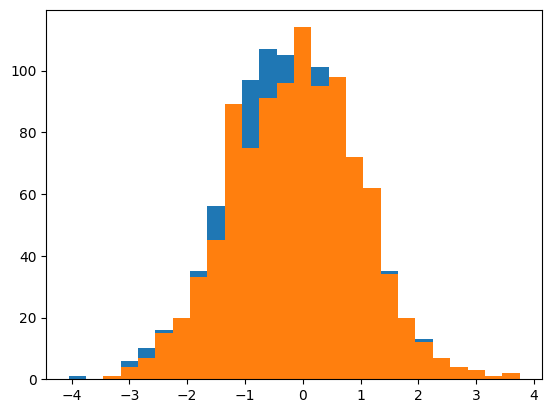

In [17]:
# both ys1 & ys2 have same mean and same std-dev
plot_histogram(ys1, 0.3), plot_histogram(ys2, 0.3)

> but each of them have a different joint distrubution with `xs`

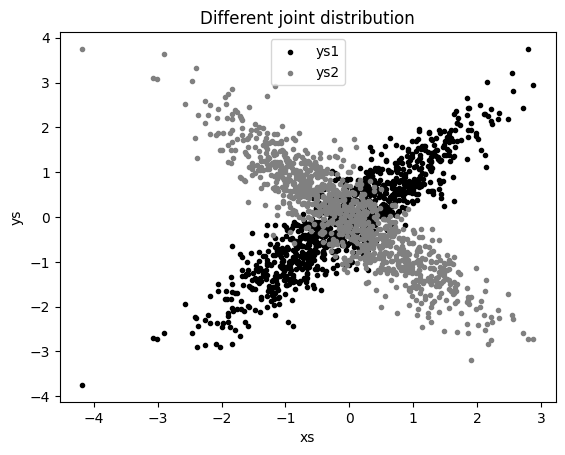

In [18]:
plt.scatter(xs, ys1, marker='.', color='black', label='ys1')
plt.scatter(xs, ys2, marker='.', color='gray', label='ys2')
plt.xlabel('xs')
plt.ylabel('ys')
plt.legend(loc=9)
plt.title("Different joint distribution")
plt.show()

In [19]:
correlation(xs, ys1), correlation(xs, ys2)

(0.901049368706566, -0.8920981526489753)

## Many dimensions
> focus is on correlation matrix

In [20]:
from support.linear_algebra import Matrix, Vector, make_matrix

In [21]:
def correlation_matrix(data: List[Vector]) -> Matrix:
    """
    Returns the len(data) x len(data) matrix whose (i, j)-th entry
    is the correlation between data[i] and data[j]
    """
    def correlation_ij(i: int, j:int) -> float:
        return correlation(data[i], data[j])

    return make_matrix(len(data), len(data), correlation_ij)

> making a scatter plot (in case not too many dimensions)

corr_data is a list of four 100-d vectors

In [22]:
series_0 = np.random.rand(100)

series_1 = -series_0 + np.random.normal(0, 0.1, 100)
series_2 = series_1 + np.random.normal(0, 0.1, 100)
series_3 = np.where(series_2 > np.median(series_2), 6, 0)
corr_data = [series_0, series_1, series_2, series_3]

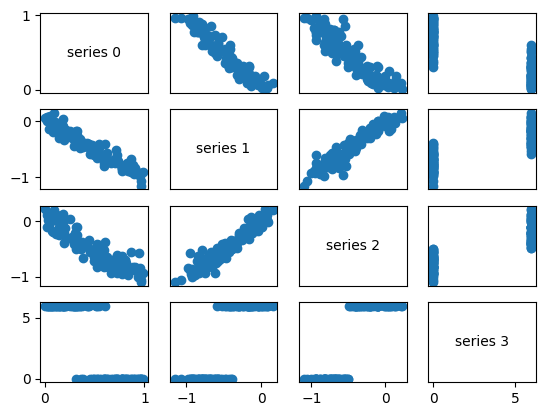

In [23]:
num_vectors = len(corr_data)
fix, ax = plt.subplots(num_vectors, num_vectors)

for i in range(num_vectors):
    for j in range(num_vectors):

        # scatter column_j on the x-axis  vs column_i on the y-axis
        if i!=j: ax[i][j].scatter(corr_data[j], corr_data[i])

        # unless i==j, in which case show the series name
        else: ax[i][j].annotate("series "+str(i), (0.5, 0.5),
                               xycoords = 'axes fraction', 
                               ha="center", va="center")
        
        # then hide axis labels except left and bottom charts
        if i < num_vectors - 1: ax[i][j].xaxis.set_visible(False)
        if j > 0: ax[i][j].yaxis.set_visible(False)


# Fix the bottom-right and top-left axis labels, which are incorrect because
# their charts only have text

ax[-1][-1].set_xlim(ax[0][-1].get_xlim())
ax[0][0].set_ylim(ax[0][1].get_ylim())

plt.show()

corr-data was not known to me, based on what is written in the book, the `corr_data` elements are reconstructed.

```
series 1 is very negatively correlated with series 0. Series 2 is positively correlated with series 1, and series 3 only takes on the values 0 and 6 with 0 corresponding to small values of series 2 and 6 correspond to large values
```

## Using NamedTuples

#### another common way of representing data is using dicts.

In [24]:
import datetime

stock_price = {'closing_price': 102.06,
              'date': datetime.date(2014, 8, 29),
              'symbol': 'AAPL'}

There are 2 issues with using `dict`:
1. a typo in an element update (instead of closing_price or symbol, one wrote cosing_price or symbl. The code will run but will do the wrong thing.
2. We can `type-annotate` uniform dictionaries, there's no helpful way to annotate dictionaries-as-data that have lots of different value types. So, one also lose th epower of type hints.


Python has `namedtuple` class - a tuple but with named slots.

In [25]:
from collections import namedtuple

StockPrice = namedtuple('StockPrice', ['symbol', 'date', 'closing_price'])
price = StockPrice('MSFT', datetime.datetime(2024, 12, 18), 416.14)

In [26]:
assert price.symbol == 'MSFT'
assert price.closing_price == 416.14

`namedtuples` are immutable

> To solve the type annotation issue, we use the type variant NamedTuple

In [27]:
from typing import NamedTuple

class StockPrice(NamedTuple):
    symbol: str
    date: datetime.date
    closing_price: float

    def is_high_tech(self) -> bool:
        """It's a class, so we can add methods too"""
        return self.symbol in ['MSFT', 'GOOG', 'FB', 'AMZN', 'AAPL']

In [28]:
price = StockPrice('MSFT', datetime.date(2024, 12, 18), 416.14)

In [29]:
assert price.symbol == 'MSFT'
assert price.closing_price == 416.14
assert price.is_high_tech()

## Dataclasses

> - mutable version of NamedTuple
> - regular python classes which generate some methods for you automatically

In [30]:
from dataclasses import dataclass

@dataclass
class StockPrice2:
    symbol: str
    date: datetime.date
    closing_price: float

    def is_high_tech(self) -> bool:
        """It's a class, so we can add methods too"""
        return self.symbol in ['MSFT', 'GOOG', 'FB', 'AMZN', 'AAPL']

In [31]:
price2 = StockPrice2('MSFT', datetime.date(2024, 12, 18), 416.14)

In [32]:
assert price2.symbol == 'MSFT'
assert price2.closing_price == 416.14
assert price2.is_high_tech()

> the big difference is that we can modify a dataclass instance's values

In [33]:
# stock split example
price2.closing_price /=2
assert price2.closing_price==208.07

> Same is not true in case of `NamedTuple`. One will get an attribute error.

_typo_ is still a problem, similar to `dicts`.

## Cleaning and Munging

In [34]:
from dateutil.parser import parse

def parse_row(row: List[str]) -> StockPrice:
    symbol, date, closing_price = row
    return StockPrice(symbol=symbol, 
                      date = parse(date).date(),
                      closing_price=float(closing_price))

In [35]:
# test function
stock = parse_row(["MSFT", "2024-12-18", "416.14"])

In [36]:
assert stock.symbol == "MSFT"
assert stock.date == datetime.date(2024, 12, 18)
assert stock.closing_price == 416.14

In [37]:
from typing import Optional
import re

def try_parse_row(row: List[str]) -> Optional[StockPrice]:
    symbol, date_, closing_price_ = row

    # Stock symbol should be all capital letters
    if not re.match(r"^[A-Z]+$", symbol):
        return None

    try:
        date = parse(date_).date()
    except ValueError:
        return None

    try:
        closing_price = float(closing_price_)
    except ValueError:
        return None

    return StockPrice(symbol, date, closing_price)

In [38]:
# Should return None for errors
assert try_parse_row(["MSFT0", "2024-12-18", "416.14"]) is None
assert try_parse_row(["MSFT", "2024-12--18", "416.14"]) is None
assert try_parse_row(["MSFT", "2024-12-18", "x"]) is None

In [39]:
assert try_parse_row(["MSFT", "2024-12-18", "416.14"])==stock

## Manipulating Data

In [40]:
data = [StockPrice(symbol='MSFT', 
                   date=datetime.date(2024, 12, 18),
                   closing_price=416.14),
        # ...
       ]

In [41]:
# Task: Find max value of a stock (avoiding infinity)

from collections import defaultdict

max_prices: Dict[str, float] = defaultdict(lambda: float('-inf'))

for sp in data:
    symbol, closing_price = sp.symbol, sp.closing_price
    if closing_price > max_prices[symbol]:
        max_prices[symbol] = closing_price

In [42]:
# Task: one day percent change

from typing import List
from collections import defaultdict

# collect the prices by symbol
prices: Dict[str, List[StockPrice]] = defaultdict(list)

for sp in data:
    prices[sp.symbol].append(sp)

In [43]:
# order the prices by date

prices = {symbol: sorted(symbol_prices) for symbol, symbol_prices in prices.items()}

In [44]:
def pct_change(yesterday: StockPrice, today: StockPrice) -> float:
    return today.closing_price / yesterday.closing_price - 1

In [45]:
class DailyChange(NamedTuple):
    symbol: str
    date: datetime.date
    pct_change: float

In [46]:
def day_over_day_changes(prices: List[StockPrice]) -> List[DailyChange]:
    """
    Assumes prices are for one stock and are in order
    """

    return [DailyChange(symbol=today.symbol, 
                        date=today.date,
                        pct_change=pct_change(yesterday, today))
           for yesterday, today in zip(prices, prices[1:])]

In [47]:
all_changes = [change
               for symbol_prices in prices.values()
               for change in day_over_day_changes(symbol_prices)]

In [48]:
# as I've not initiated any symbol prices or any other datasets, 
# I am simply avoiding the error by using a default here

max_change = max(all_changes, key=lambda change: change.pct_change, default="No data")
min_change = max(all_changes, key=lambda change: change.pct_change, default="No data")

## Rescaling

In [49]:
from support.linear_algebra import distance

In [50]:
# Dummy dataset with person, height (in cm), and weight (in kgs)
data = [
    {"person": "Alice", "height": 160, "weight": 60},
    {"person": "Bob", "height": 175, "weight": 82},
    {"person": "Charlie", "height": 168, "weight": 68},
    {"person": "Diana", "height": 170, "weight": 75},
    {"person": "Ethan", "height": 180, "weight": 85}
]

In [51]:
# using Euclidean distance

for i in range(len(data)):
    for j in range(i + 1, len(data)):
        person_a = data[i]
        person_b = data[j]
        point_a = [person_a['height'], person_a['weight']]
        point_b = [person_b['height'], person_b['weight']]
        dist = distance(point_a, point_b)
        print(f"Distance between {person_a['person']} and {person_b['person']}: {dist:.2f}")

Distance between Alice and Bob: 26.63
Distance between Alice and Charlie: 11.31
Distance between Alice and Diana: 18.03
Distance between Alice and Ethan: 32.02
Distance between Bob and Charlie: 15.65
Distance between Bob and Diana: 8.60
Distance between Bob and Ethan: 5.83
Distance between Charlie and Diana: 7.28
Distance between Charlie and Ethan: 20.81
Distance between Diana and Ethan: 14.14


> If there is another feature in the dataset, the distance in this way will be affected by it.

Dimensions aren't comparable here.

_Time to rescale._

In [52]:
from typing import Tuple

from support.linear_algebra import vector_mean
from support.statistics import stddev

In [53]:
def scale(data: List[Vector]) -> Tuple[Vector, Vector]:
    """ returns the mean and std-dev for each position"""

    dim = len(data[0])

    means = vector_mean(data)
    stdevs = [stddev([vector[i] for vector in data]) 
              for i in range(dim)]

    return means, np.round(stdevs)

In [54]:
vectors = [[-3,-1,1],[-1,0,1],[1,1,1]]
means, stdevs = scale(vectors)

assert means == [-1,0,1]
assert np.array_equal(stdevs, np.array([3., 1., 0.])), "Standard deviations do not match"

## tqdm - one of my fav¶

In [55]:
# iterable wrapped in tqdm.tqdm will produce a progress bar

import tqdm
for i in tqdm.tqdm(range(100)):
    #
    _ = [random.random() for _ in range(1000000)]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.24it/s]


> it can't do this, if you use a generator

In [56]:
# to set a description

from typing import List

def primes_up_to(n: int) -> List[int]:
    primes = [2]

    with tqdm.trange(3, n) as t:
        for i in t:
            # i is prime if no smaller prime divides it
            i_is_prime = not any(i%p==0 for p in primes)
            if i_is_prime:
                primes.append(i)
            t.set_description(f"{len(primes)} primes")
    return primes

In [57]:
my_primes = primes_up_to(1000)

168 primes: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 997/997 [00:00<00:00, 2959.13it/s]


## Dimensionality reduction

1. Translate data so that each dimension has mean 0.

In [58]:
from support.linear_algebra import subtract

def de_mean(data: List[Vector]) -> List[Vector]:
    """Recenters the data to have mean 0 in every dimension"""

    mean = vector_mean(data)
    return [subtract(vector, mean) for vector in data]


# if we don't do this, the technique we are implementing might identify the mean itself rather than the variation of the data

2. From a de-meaned matrix X, what is the direction that captures the greatest variance in the data.

> Given a direction `d` (a vector of magnitude 1), each row x in the matrix extends `dot(x,d)` in the `d` direction.    
> And every nonzero vector w determines a direction if we rescale it to have magnitude 1.

In [59]:
from support.linear_algebra import magnitude

def direction(w: Vector)-> Vector:
    mag = magnitude(w)
    return [w_i / mag for w_i in w]

> a non-zero vector `w`, we can compute the variance of our dataset in the direction determined by `w`

In [60]:
from support.linear_algebra import dot

def directional_variance(data: List[Vector], w: Vector) -> float:
    """
    Returns the variance of x in the direction of w
    """
    w_dir = direction(w)
    return sum(dot(v, w_dir) ** 2 for v in data)

- find the direction that maximizes this variance.
- using gradient descent

In [61]:
def directional_variance_gradient(data: List[Vector], w: Vector) -> Vector:
    """
    The gradient of directional variance wrt w
    """
    w_dir = direction(w)
    return [sum(2*dot(v, w_dir) * v[i] for v in data) for i in range(len(w))]

for the first principal component - find the direction that maximizes the `directional_variance` function

In [62]:
from support.gradient_descent import gradient_step

In [65]:
def first_principal_component(data: List[Vector], n: int = 100, step_size: float = 0.1) -> Vector:
    # random guess

    guess = [1.0 for _ in data[0]]

    with tqdm.trange(n) as t:
        for _ in t:
            dv = directional_variance(data, guess)
            gradient = directional_variance_gradient(data, guess)
            guess = gradient_step(guess, gradient, step_size)
            t.set_description(f"dv: {dv:.3f}")
    return direction

In [66]:
# project our data onto it to find the values of that component

from support.linear_algebra import scalar_multiply
def project(v: Vector, w: Vector) -> Vector:
    """return the projection of v onto the direction w"""
    projection_length = dot(v,w)
    return scalar_multiply(projection_length, w)

In [67]:
# for further components, remove the projections first

from support.linear_algebra import subtract

def remove_projections_from_vector(v: Vector, w: Vector) -> Vector:
    """projects v onto w and subtracts the result from v"""
    return subtract(v, project(v, w))

def remove_projection(data: List[Vector], w: Vector) -> List[Vector]:
    return [remove_projections_from_vector(v,w) for v in data]

On a higher dimensional dataset, iteratively more components can be found.

In [68]:
def pca(data: List[Vector], num_components: int) -> List[Vector]:
    components: List[Vector] = []
    for _ in range(num_components):
        component = first_principal_component(data)
        components.append(component)
        data = remove_projection(data, component)

    return components

> transform data into the lower-dimensional space spanned by the components

In [69]:
def transorm_vector(v: Vector, components:List[Vector]) -> Vector:
    return [dot(v,w) for w in components]

def transform(data: List[Vector], components: List[Vector]) -> List[Vector]:
    return [transform_vector(v, components) for v in data]

## Script Complete